In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from tea import *

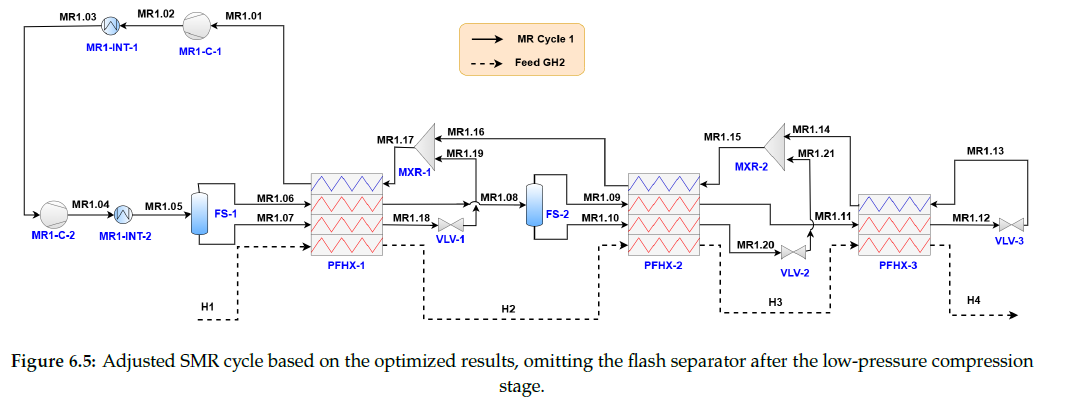

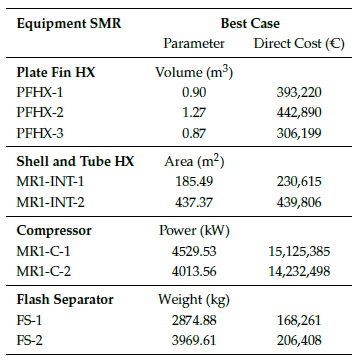

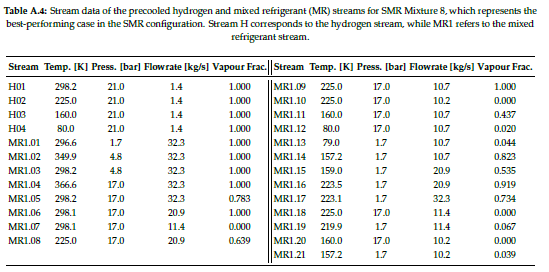

In [ ]:
comp_1_pwr = 4529.53  # kW
comp_2_pwr = 4013.56  # kW
motor_comp_1_pwr = comp_1_pwr / 0.9  # kW
motor_comp_2_pwr = comp_2_pwr / 0.9  # kW

# Creating objects for the process equipment
comp_1 = Equipment(
    name='Comp-1', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=comp_1_pwr, # kW
    type='Compressor', 
    subtype='Centrifugal'
)

motor_comp_1 = Equipment(
    name='Motor-1', 
    process_type='Electrical', 
    material='Carbon steel', 
    param=motor_comp_1_pwr,  # kW, adjusted for efficiency
    type='Motor/generator', 
    subtype='Totally enclosed'
)

comp_2 = Equipment(
    name='Comp-2', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=comp_2_pwr, # kW 
    type='Compressor', 
    subtype='Centrifugal'
)

motor_comp_2 = Equipment(
    name='Motor-2', 
    process_type='Electrical', 
    material='Carbon steel', 
    param=motor_comp_2_pwr,  # kW, adjusted for efficiency
    type='Motor/generator', 
    subtype='Totally enclosed'
)

intercooler_1 = Equipment(
    name='Intercooler-1', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=185.49,  # m2
    type='Heat exchanger', 
    subtype='U-tube shell & tube'
)

intercooler_2 = Equipment(
    name='Intercooler-2', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=437.37,  # m2
    type='Heat exchanger', 
    subtype='U-tube shell & tube'
)

pfhx_1 = Equipment(
    name='PlateFinHX-1', 
    process_type='Fluids', 
    material='Aluminum', 
    param=0.90,  # m3
    type='Heat exchanger', 
    subtype='Plate fin four-streams'
)

pfhx_2 = Equipment(
    name='PlateFinHX-2', 
    process_type='Fluids', 
    material='Aluminum', 
    param=1.27,  # m3
    type='Heat exchanger', 
    subtype='Plate fin four-streams'
)

pfhx_3 = Equipment(
    name='PlateFinHX-3', 
    process_type='Fluids', 
    material='Aluminum', 
    param=0.87,  # m3
    type='Heat exchanger', 
    subtype='Plate fin three-streams'
)

flash_1 = Equipment(
    name='FlashSeparator-1', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=2874.88,  # kg
    type='Vessel', 
    subtype='Vertical CS'
)

flash_2 = Equipment(
    name='FlashSeparator-2', 
    process_type='Fluids', 
    material='Carbon steel', 
    param=3969.61,  # kg
    type='Vessel', 
    subtype='Vertical CS'
)

In [3]:
config = {
    'process_type': 'Mixed',
    'country': 'Netherlands',
    'region': None,
    # List all the process equipment objects that have been created below
    # This is for calculating the ISBL cost
    'equipment': [
        comp_1,
        # motor_comp_1,
        comp_2,
        # motor_comp_2,
        intercooler_1,
        intercooler_2,
        pfhx_1,
        pfhx_2,
        pfhx_3,
        flash_1,
        flash_2
    ]
}

In [4]:
isbl, osbl, dne, x, fci = calculate_fixed_capital(config)

# Print the resultS
print("Capital Cost Estimation")
print("===================================")
print(f"ISBL: ${isbl:,.2f}")
print(f"OSBL: ${osbl:,.2f}")
print(f"Design and Engineering: ${dne:,.2f}")
print(f"Contingency: ${x:,.2f}")
print(f"Fixed Capital Investment: ${fci:,.2f}")

Capital Cost Estimation
ISBL: $43,082,923.02
OSBL: $17,233,169.21
Design and Engineering: $15,079,023.06
Contingency: $6,031,609.22
Fixed Capital Investment: $81,426,724.51


In [40]:
config.update({
    'variable_opex_inputs': {
        'electricity': {
            'consumption': (motor_comp_1_pwr+motor_comp_2_pwr)*8322, # kWh/year
            'price': 0.10,                               # USD/kWh
            'price_std': 0.025/2,
            'price_max': 3,
            'price_min': 0.01
        },
        'refrigerant': {
            'consumption': 1.5*8322, # kg/year
            'price': 5,              # USD/kg
            'price_std': 3/2,
            'price_max': 15,
            'price_min': 1
        }
        # Add more variable opex items as needed        
    }
})

NameError: name 'motor_comp_1_pwr' is not defined

In [ ]:
variable_production_costs = calculate_variable_opex(config)

# Print the results
print(f"Variable OPEX: ${variable_production_costs:,.2f} per year")

Variable OPEX: $7,171,974.50 per year


In [41]:
config.update({
    'working_capital': 0.15*config['fixed_capital'],  # Common assumption for working capital: 15% of the fixed capital
    'interest_rate': 0.09,  # The annual interest rate used for financing, here set at 9%.
    'operator_hourly_rate': 20  # The hourly rate of 1 process plant operator (in US$/hour)
})

In [42]:
fixed_production_costs = calculate_fixed_opex(config)

# Print the results
print("Operating Cost Estimation")
print("===================================")
print(f"Variable OPEX: ${variable_production_costs:,.2f}")
print(f"Fixed OPEX: ${fixed_production_costs:,.2f}")
print(f"Total OPEX: ${fixed_production_costs+variable_production_costs:,.2f}")

Operating Cost Estimation
Variable OPEX: $7,171,974.50
Fixed OPEX: $8,521,368.39
Total OPEX: $15,693,342.89


In [43]:
config.update({
    'project_lifetime': 20,  # in years
    'annual_prod': 125*1000*8322/24,  # in unit per year
    'product_price': 0,  # in currency per unit
    'tax_rate': 0,  # assuming 30% tax rate
})

In [44]:
create_cash_flow_table(config)

,Year,Capital cost,Production [unit],Revenue,Cash cost of prod.,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow,PV of cash flow,NPV
0,1,"$24,428,017.35",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,"$-24,428,017.35","$-22,411,025.09","$-22,411,025.09"
1,2,"$48,856,034.70",$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,"$-48,856,034.70","$-41,121,146.96","$-63,532,172.06"
2,3,"$20,356,681.13","$17,337,500.00",$0.00,"$11,390,158.19","$-11,390,158.19",$0.00,"$-11,390,158.19",$0.00,"$-31,746,839.32","$-24,514,384.87","$-88,046,556.92"
3,4,$0.00,"$34,675,000.00",$0.00,"$14,258,947.99","$-14,258,947.99",$0.00,"$-14,258,947.99",$0.00,"$-14,258,947.99","$-10,101,398.24","$-98,147,955.16"
4,5,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-10,199,596.10","$-108,347,551.26"
5,6,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-9,357,427.62","$-117,704,978.88"
6,7,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-8,584,795.98","$-126,289,774.85"
7,8,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-7,875,959.61","$-134,165,734.47"
8,9,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-7,225,651.02","$-141,391,385.49"
9,10,$0.00,"$43,343,750.00",$0.00,"$15,693,342.89","$-15,693,342.89",$0.00,"$-15,693,342.89",$0.00,"$-15,693,342.89","$-6,629,037.63","$-148,020,423.12"


In [45]:
print(f"LCOP: ${round(calculate_levelized_cost(config),3)}/unit")

LCOP: $0.643/unit


In [46]:
print(round(calculate_levelized_cost(config),3)*0.88)

0.56584


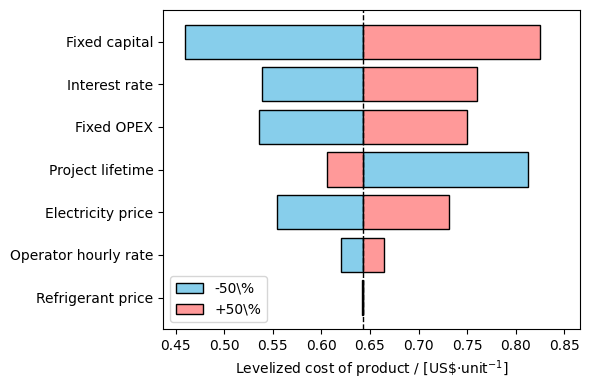

In [47]:
tornado_plot(config, plus_minus_value=0.5)

In [48]:
# lcohs = monte_carlo(config, num_samples=1_000_000, batch_size=1000, show_input_distributions=False)